# Reviews Sentiment Analysis

In [1]:
# import libraries
import gzip
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading the data
gz_filename = 'listings.csv.gz'

# Read the GZ-compressed CSV file into a pandas DataFrame
with gzip.open(gz_filename, 'rt', encoding='utf-8') as gz_file:
    listings = pd.read_csv(gz_file)


review = pd.read_csv('all_reviews.csv')    
neighbourhoods_geo = gpd.read_file('neighbourhoods.geojson')

In [3]:
# Print basic information about the Reviews dataset
print("Reviews Dataset Info:")
print(review.info())

# Display the first few rows of the Reviews dataset
print("\nSample Rows from Reviews Dataset:")
print(review.head())

Reviews Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315479 entries, 0 to 315478
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   listing_id         315479 non-null  int64 
 1   id                 315479 non-null  int64 
 2   date               315479 non-null  object
 3   reviewer_id        315479 non-null  int64 
 4   reviewer_name      315479 non-null  object
 5   comments           315479 non-null  object
 6   detected_language  315479 non-null  object
dtypes: int64(3), object(4)
memory usage: 16.8+ MB
None

Sample Rows from Reviews Dataset:
   listing_id      id        date  reviewer_id  reviewer_name  \
0        3176    4283  2009-06-20        21475          Milan   
1        3176  134722  2010-11-07       263467         George   
2        3176  144064  2010-11-24        76726       Patricia   
3        3176  165048  2011-01-04       279789           Aude   
4        3176  16978

In [4]:
# Print basic information about the Neighbourhoods GeoJSON dataset
print("Neighbourhoods GeoJSON Dataset Info:")
print(neighbourhoods_geo.info())

# Display the first few rows of the Neighbourhoods GeoJSON dataset
print("\nSample Rows from Neighbourhoods GeoJSON Dataset:")
print(neighbourhoods_geo.head())

Neighbourhoods GeoJSON Dataset Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        138 non-null    object  
 1   neighbourhood_group  138 non-null    object  
 2   geometry             140 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 3.4+ KB
None

Sample Rows from Neighbourhoods GeoJSON Dataset:
                               neighbourhood   neighbourhood_group  \
0             Blankenfelde/Niederschönhausen                Pankow   
1                             Helmholtzplatz                Pankow   
2                         Wiesbadener Straße  Charlottenburg-Wilm.   
3  Schmöckwitz/Karolinenhof/Rauchfangswerder    Treptow - Köpenick   
4                                 Müggelheim    Treptow - Köpenick   

                                            geometry  
0  MULTIPOLY

### Handling Missing Values

In [5]:
# Check for missing values in the reviews dataset
print(review.isnull().sum())

# Output the percentage of missing values
print(review.isnull().mean() * 100)

listing_id           0
id                   0
date                 0
reviewer_id          0
reviewer_name        0
comments             0
detected_language    0
dtype: int64
listing_id           0.0
id                   0.0
date                 0.0
reviewer_id          0.0
reviewer_name        0.0
comments             0.0
detected_language    0.0
dtype: float64


### Selecting English Reviews

In [6]:
# Filter the dataset to include only English comments
comments = review['comments']
comments

0         excellent stay, i would highly recommend it. a...
1         Britta's apartment in Berlin is in a great are...
2         Fantastic, large place in good location. Only ...
3         We went in Berlin for the new year eve. The ap...
4         Location, location, location! Britta's place w...
                                ...                        
315474     Everything went well, Mathias and Anne were b...
315475    Small but very nice apartment. Equipped with t...
315476     Subway and tram stops right in front of the d...
315477    "…Very warm welcome from Florian and his wife ...
315478     It worked out well, new apartment.<br/>Large ...
Name: comments, Length: 315479, dtype: object

# Data Cleaning

In [7]:
import spacy

# Load spaCy's English tokenizer and language model
nlp = spacy.load('en_core_web_sm')

# Define a function for text preprocessing (tokenization and lemmatization)
def preprocess_text(text):
    text = text.replace("<br/>", "")
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    return ' '.join(tokens)

# Apply text preprocessing to the English comments
review_preprocessed = comments.apply(preprocess_text)

# Topic Modeling - LDA

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import STOPWORDS
import re

# Load the English stopwords
stop_words = set(STOPWORDS)
stop_words.update(['arent', 'cant', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'heres', 'hes', 'hows', 'id', 'ill', 'im', 'isnt', 'ive', 'lets', 'mustnt', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'thats', 'theres', 'theyd', 'theyll', 'theyre', 'theyve', 'wasnt', 'wed', 'well', 'werent', 'weve', 'whats', 'whens', 'wheres', 'whos', 'whys', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'])

# Custom tokenizer function to handle abbreviations and remove special characters
def custom_tokenizer(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    # Handle contractions like "it's"
    text = re.sub(r"(\w+)('s)", r"\1\2", text)
    tokens = text.split()  # Basic tokenization by splitting on spaces
    # Join "br" and "bedroom" tokens if found consecutively
    tokens = [re.sub(r'(^|\s+)br($|\s+)', 'bedroom', token) for token in tokens]
    return tokens

# Step 2: Prepare Text Data for LDA
# Convert the preprocessed English comments into a document-term matrix using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.95, min_df=2, tokenizer=custom_tokenizer)
dtm = vectorizer.fit_transform(review_preprocessed)

In [9]:
# Step 3: Train the LDA Model
num_topics = 5  # You can adjust this number based on your preference
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Step 4: Extract Main Topics
def get_main_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        topics[f"Topic {topic_idx + 1}"] = [words[i] for i in top_words_idx]
    return topics

main_topics = get_main_topics(lda_model, vectorizer)
for topic, words in main_topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: great, apartment, stay, location, place, recommend, host, clean, easy, berlin
Topic 2: everything, great, apartment, nice, thank, stay, accommodation, back, come, location
Topic 3: apartment, stay, room, great, place, good, nice, bed, berlin, location
Topic 4: great, nice, place, location, stay, good, apartment, clean, host, perfect
Topic 5: arrival, reservation, cancel, day, posting, automated, host, ok, stay, place


In [17]:
# Step 2: Prepare Text Data for LDA
# Convert the preprocessed English comments into a document-term matrix using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.90, min_df=10,  ngram_range=(3, 3), sublinear_tf=True, use_idf=True, tokenizer=custom_tokenizer)
dtm = vectorizer.fit_transform(review_preprocessed)

# Step 3: Train the LDA Model
num_topics = 5  # You can adjust this number based on your preference
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Step 4: Extract Main Topics
def get_main_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        topics[f"Topic {topic_idx + 1}"] = [words[i] for i in top_words_idx]
    return topics

main_topics = get_main_topics(lda_model, vectorizer)
for topic, words in main_topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: apartment great location, great apartment great, u bahn station, close u bahn, nice apartment great, clean everything need, great location close, s bahn station, stay highly recommend, stay next time
Topic 2: great location great, great place great, place great location, apartment good location, great location easy, host highly recommend, great host great, nice apartment good, apartment everything need, location great host
Topic 3: day arrival automated, arrival automated posting, host cancel reservation, really enjoy stay, nice place stay, good place stay, place stay berlin, definitely come back, close public transport, easy access public
Topic 4: love come back, great location nice, flat great location, clean great location, nice place great, place great location, s place great, clean good location, perfect place stay, definitely recommend stay
Topic 5: great place stay, great location clean, place good location, love come back, place stay berlin, really nice place, close pu

In [10]:
# Step 2: Prepare Text Data for LDA
# Convert the preprocessed English comments into a document-term matrix using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.95, min_df=10,  ngram_range=(3, 3), sublinear_tf=True, use_idf=True, tokenizer=custom_tokenizer)
dtm = vectorizer.fit_transform(review_preprocessed)

# Step 3: Train the LDA Model
num_topics = 3  # You can adjust this number based on your preference
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Step 4: Extract Main Topics
def get_main_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        topics[f"Topic {topic_idx + 1}"] = [words[i] for i in top_words_idx]
    return topics

main_topics = get_main_topics(lda_model, vectorizer)
for topic, words in main_topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: apartment great location, close u bahn, great location clean, great apartment great, apartment everything need, u bahn station, good value money, great location nice, love come back, great location close
Topic 2: great place stay, apartment good location, place great location, great location great, great place great, place good location, great location easy, place stay berlin, highly recommend stay, perfect place stay
Topic 3: day arrival automated, arrival automated posting, host cancel reservation, really enjoy stay, nice place stay, good place stay, close public transport, place stay berlin, definitely come back, love come back


In [11]:
# Step 2: Prepare Text Data for LDA
# Convert the preprocessed English comments into a document-term matrix using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.95, min_df=20,  ngram_range=(3, 3), sublinear_tf=True, use_idf=True, tokenizer=custom_tokenizer)
dtm = vectorizer.fit_transform(review_preprocessed)

# Step 3: Train the LDA Model
num_topics = 3  # You can adjust this number based on your preference
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Step 4: Extract Main Topics
def get_main_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        topics[f"Topic {topic_idx + 1}"] = [words[i] for i in top_words_idx]
    return topics

main_topics = get_main_topics(lda_model, vectorizer)
for topic, words in main_topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: arrival automated posting, day arrival automated, host cancel reservation, great location great, close public transport, great location clean, 5 minute walk, within walking distance, u bahn station, really enjoy stay
Topic 2: great place stay, place stay berlin, apartment great location, place great location, nice place stay, good place stay, great place great, good value money, great apartment great, apartment everything need
Topic 3: love come back, really enjoy stay, definitely come back, within walk distance, make feel home, will come back, apartment good location, highly recommend stay, close u bahn, will definitely come


In [12]:
# Create a list to store the topics for each review
topic_lists = []

# Loop through each review's vector representation and find the dominant topic
for review_vec in dtm:
    # Get the dominant topic for the review
    dominant_topic = lda_model.transform(review_vec)[0].argmax()
    
    # Append the topic to the list
    topic_lists.append(f"Topic {dominant_topic + 1}")

# Add the list of topics to the english_review DataFrame
review['lda_topics'] = topic_lists

In [13]:
topic = {
    "Topic 1": "Convenience and Location",
    "Topic 2": "Quality Accommodations",
    "Topic 3": "Positive Guest Experiences"
}

# Map topic numbers to names and add a new column 'lda_topic_names' to the DataFrame
review['topic'] = review['lda_topics'].map(topic)

In [14]:
review

,listing_id,id,date,reviewer_id,reviewer_name,comments,detected_language,lda_topics,topic
0,3176,4283,2009-06-20,21475,Milan,"excellent stay, i would highly recommend it. a...",en,Topic 2,Quality Accommodations
1,3176,134722,2010-11-07,263467,George,Britta's apartment in Berlin is in a great are...,en,Topic 2,Quality Accommodations
2,3176,144064,2010-11-24,76726,Patricia,"Fantastic, large place in good location. Only ...",en,Topic 3,Positive Guest Experiences
3,3176,165048,2011-01-04,279789,Aude,We went in Berlin for the new year eve. The ap...,en,Topic 2,Quality Accommodations
4,3176,169789,2011-01-12,49570,David + Tiila,"Location, location, location! Britta's place w...",en,Topic 1,Convenience and Location
...,...,...,...,...,...,...,...,...,...
315474,13755615,417916073420394703,2021-07-30,111008890,Dani,"Everything went well, Mathias and Anne were b...",en,Topic 2,Quality Accommodations
315475,13755615,422214321929921759,2021-08-05,410412862,Emilia,Small but very nice apartment. Equipped with t...,en,Topic 2,Quality Accommodations
315476,13755615,427257539772742031,2021-08-12,415419553,Horst,Subway and tram stops right in front of the d...,en,Topic 1,Convenience and Location
315477,13755615,430140382132109742,2021-08-16,288883639,Victorino,"""…Very warm welcome from Florian and his wife ...",en,Topic 3,Positive Guest Experiences


# Sentiment Analysis - VADER

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Create a function to get sentiment labels based on the compound score
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Calculate sentiment scores for each review
review['sentiment_scores'] = review['comments'].apply(lambda x: sid.polarity_scores(x))
review['sentiment_labels'] = review['sentiment_scores'].apply(lambda x: get_sentiment_label(x['compound']))

# Print the sentiment labels and their counts
sentiment_counts = review['sentiment_labels'].value_counts()
print(sentiment_counts)

sentiment_labels
Positive    303693
Neutral       6421
Negative      5365
Name: count, dtype: int64


# Data Visualizations

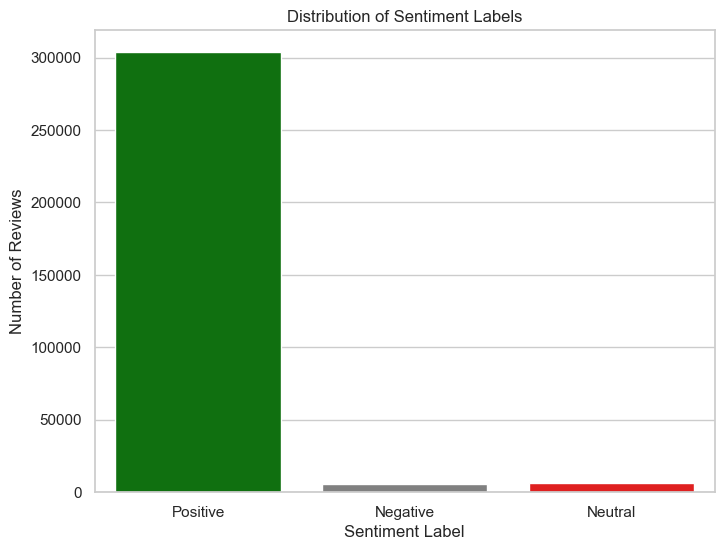

In [16]:
# Function to plot sentiment distribution for a given language
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=review['sentiment_labels'],palette=["green", "gray", "red"])
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Labels')
plt.show()

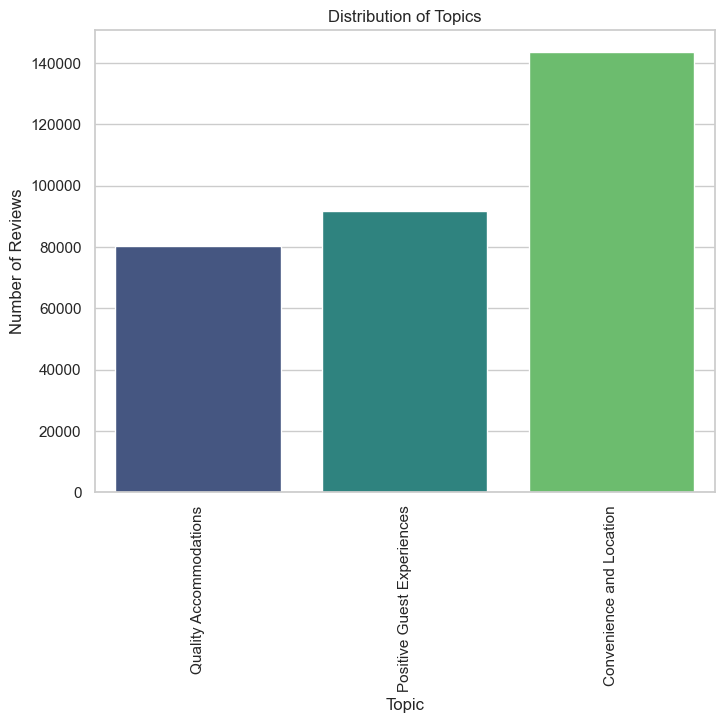

In [17]:
# Function to plot sentiment distribution for a given language
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=review['topic'],palette='viridis')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Topics')
plt.xticks(rotation=90)
plt.show()

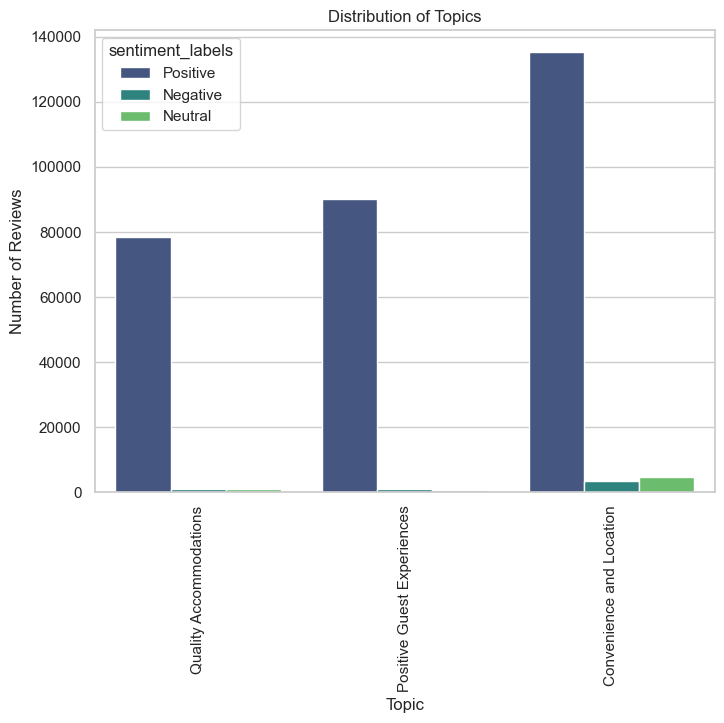

In [18]:
# Function to plot sentiment distribution for a given language
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=review, x='topic', hue='sentiment_labels',palette='viridis')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Topics')
plt.xticks(rotation=90)
plt.show()

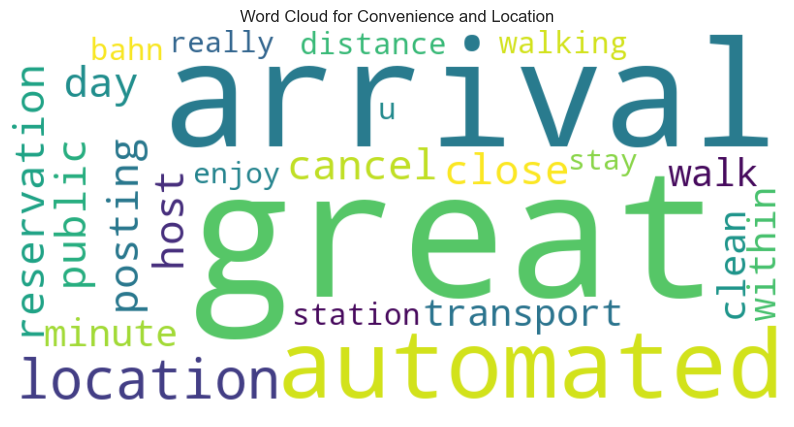

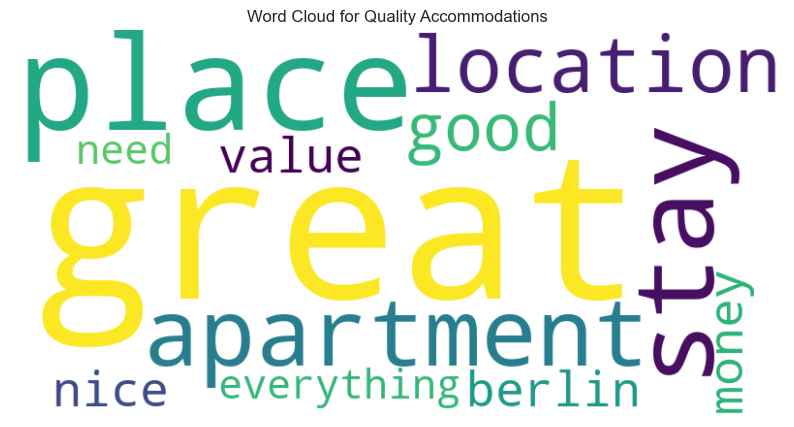

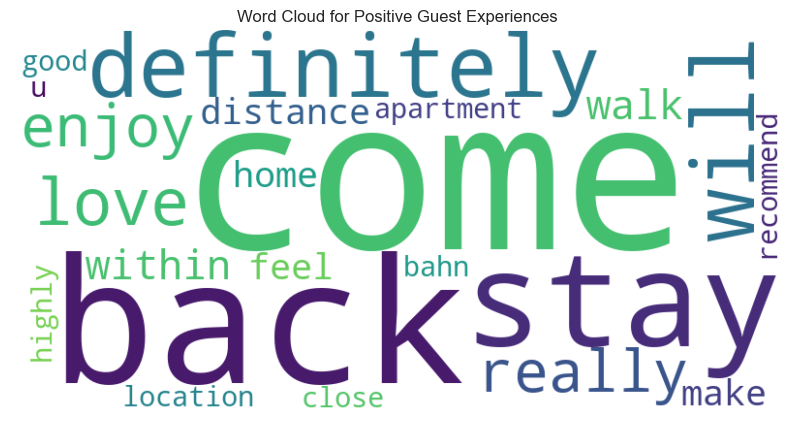

In [19]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_id, words in main_topics.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {topic[topic_id]}')  # Update the title here
    plt.axis('off')
    plt.show()

In [20]:
import ast 

# Group by 'listing_id' and aggregate sentiment data
listing_sentiments = review.groupby('listing_id').agg({
    'topic': lambda x: x.mode().iloc[0],
    'sentiment_labels': lambda x: x.mode().iloc[0],  # Get the most frequent sentiment label
}).reset_index()  # Reset the index to make 'listing_id' a column again

# Rename the columns for clarity
listing_sentiments.rename(columns={
    'topic': 'most_frequent_topic',
    'sentiment_labels': 'most_frequent_sentiment',
}, inplace=True)

# Now 'listing_sentiments' dataframe contains aggregated sentiment data at the listing level
listing_sentiments

,listing_id,most_frequent_topic,most_frequent_sentiment
0,3176,Convenience and Location,Positive
1,9991,Convenience and Location,Positive
2,14325,Convenience and Location,Positive
3,16644,Convenience and Location,Positive
4,17904,Convenience and Location,Positive
...,...,...,...
9616,907870068509041383,Convenience and Location,Positive
9617,908534380022514522,Convenience and Location,Positive
9618,910010093044817328,Convenience and Location,Positive
9619,911247748100456770,Convenience and Location,Neutral


In [24]:
# Subset the desired columns from the listings dataset
desired_columns = [
    'id', 'listing_url', 'name', 'description', 'picture_url', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
    'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
    'amenities', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]

listings_subset = listings[desired_columns]

# Merge the english_review dataset with the listings_subset dataset
df = pd.merge(listing_sentiments, listings_subset, left_on='listing_id', right_on='id', how='left')

# Drop the duplicate 'id' column from the merge
df.drop(columns=['listing_id'], inplace=True)

df

,most_frequent_topic,most_frequent_sentiment,id,listing_url,name,description,picture_url,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,beds,amenities,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,Convenience and Location,Positive,3176,https://www.airbnb.com/rooms/3176,Rental unit in Berlin · ★4.63 · 1 bedroom · 2 ...,This beautiful first floor apartment is situa...,https://a0.muscache.com/pictures/243355/84afcf...,Prenzlauer Berg Südwest,Pankow,Entire rental unit,...,2.0,"[""Hair dryer"", ""Hangers"", ""Kitchen"", ""Carbon m...",148,4.63,4.67,4.52,4.64,4.69,4.92,4.62
1,Convenience and Location,Positive,9991,https://www.airbnb.com/rooms/9991,Rental unit in Berlin · ★5.0 · 4 bedrooms · 7 ...,4 bedroom with very large windows and outstand...,https://a0.muscache.com/pictures/42799131/59c8...,Prenzlauer Berg Südwest,Pankow,Entire rental unit,...,7.0,"[""Wifi"", ""Babysitter recommendations"", ""Smoke ...",8,5.00,5.00,5.00,5.00,5.00,4.86,4.86
2,Convenience and Location,Positive,14325,https://www.airbnb.com/rooms/14325,Rental unit in Berlin · ★4.67 · Studio · 1 bed...,The apartment is located on the upper second f...,https://a0.muscache.com/pictures/508703/24988a...,Prenzlauer Berg Nordwest,Pankow,Entire rental unit,...,1.0,"[""Hangers"", ""Kitchen"", ""Wifi"", ""TV"", ""Dishes a...",26,4.67,5.00,4.84,4.68,4.84,4.58,4.42
3,Convenience and Location,Positive,16644,https://www.airbnb.com/rooms/16644,Condo in Berlin · ★4.72 · 1 bedroom · 3 beds ·...,Light and sunny 2-Room-turn of the century-fla...,https://a0.muscache.com/pictures/73759174/e2ef...,nördliche Luisenstadt,Friedrichshain-Kreuzberg,Entire condo,...,3.0,"[""Hair dryer"", ""Hangers"", ""Kitchen"", ""Carbon m...",48,4.72,4.86,4.86,4.93,4.86,4.67,4.71
4,Convenience and Location,Positive,17904,https://www.airbnb.com/rooms/17904,Rental unit in Berlin · ★4.77 · Studio · 1 bed...,"- apt is available starting April 1, 2023<br /...",https://a0.muscache.com/pictures/d9a6f8be-54b9...,Reuterstraße,Neukölln,Entire rental unit,...,1.0,"[""Hair dryer"", ""Hangers"", ""Kitchen"", ""Wifi"", ""...",299,4.77,4.82,4.71,4.89,4.92,4.87,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9616,Convenience and Location,Positive,907870068509041383,https://www.airbnb.com/rooms/907870068509041383,Rental unit in Berlin · ★New · 1 bedroom · 1 b...,Enjoy a great experience at my centrally-locat...,https://a0.muscache.com/pictures/miso/Hosting-...,Düsseldorfer Straße,Charlottenburg-Wilm.,Entire rental unit,...,1.0,"[""Wifi"", ""Smoke alarm"", ""Refrigerator"", ""Iron""...",2,5.00,5.00,5.00,5.00,5.00,5.00,5.00
9617,Convenience and Location,Positive,908534380022514522,https://www.airbnb.com/rooms/908534380022514522,Rental unit in Berlin · ★New · 1 bedroom · 2 b...,<b>License number</b><br />First name and Last...,https://a0.muscache.com/pictures/miso/Hosting-...,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,Private room in rental unit,...,2.0,"[""Kitchen"", ""Dedicated workspace"", ""Wifi"", ""Lo...",1,5.00,5.00,5.00,5.00,5.00,5.00,5.00
9618,Convenience and Location,Positive,910010093044817328,https://www.airbnb.com/rooms/910010093044817328,Rental unit in Berlin · ★New · Studio · 1 bed ...,Fully furnished Studio flat on Lichtenberg Sta...,https://a0.muscache.com/pictures/35f13c43-6eb3...,Frankfurter Allee Süd,Lichtenberg,Entire rental unit,...,1.0,"[""Wifi"", ""Refrigerator"", ""Free parking on prem...",1,5.00,5.00,5.00,5.00,5.00,5.00,5.00
9619,Convenience and Location,Neutral,911247748100456770,https://www.airbnb.com/rooms/911247748100456770,Rental unit in Berlin · ★New · 1 bedroom · 1 b...,Relax with the whole family at this peaceful p...,https://a0.muscache.com/pictures/miso/Hosting-...,Schöneberg-Süd,Tempelhof - Schöneberg,Shared room in rental unit,...,1.0,"[""Kitchen"", ""Wifi"", ""TV"", ""Washer"", ""

In [25]:
# Merge the merged_df dataset with the neighbourhoods_geo dataset
df = pd.merge(
    df,
    neighbourhoods_geo,
    left_on=['neighbourhood_cleansed', 'neighbourhood_group_cleansed'],
    right_on=['neighbourhood', 'neighbourhood_group'],
    how='left'
)


In [26]:
df.columns

Index(['most_frequent_topic', 'most_frequent_sentiment', 'id', 'listing_url',
       'name', 'description', 'picture_url', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'amenities', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'neighbourhood', 'neighbourhood_group',
       'geometry'],
      dtype='object')

In [27]:
# Drop duplicate columns that were brought in from the merge
df = df.drop(['neighbourhood_cleansed','neighbourhood_group_cleansed'], axis=1)

In [28]:
# Check for missing values in the reviews dataset
print(df.isnull().sum())

# Output the percentage of missing values
print(df.isnull().mean() * 100)

most_frequent_topic               0
most_frequent_sentiment           0
id                                0
listing_url                       0
name                              0
description                      72
picture_url                       0
property_type                     0
room_type                         0
accommodates                      0
bedrooms                       3598
beds                            115
amenities                         0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy          109
review_scores_cleanliness       107
review_scores_checkin           112
review_scores_communication     108
review_scores_location          112
review_scores_value             114
neighbourhood                     0
neighbourhood_group               0
geometry                          0
dtype: int64
most_frequent_topic             0.000000
most_frequent_sentiment         0.000000
id                              0.000000


In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Columns to impute with regression-based imputation
columns_to_impute = [
    'bedrooms', 'review_scores_value', 'review_scores_checkin', 'review_scores_location',
    'review_scores_accuracy','review_scores_communication', 'review_scores_cleanliness','beds']

# Convert specified columns to whole numbers
columns_to_convert_to_int = ['beds','bedrooms']


# Use regression-based imputation
imputer = IterativeImputer()
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Convert specified columns to whole numbers
df[columns_to_convert_to_int] = df[columns_to_convert_to_int].astype(int)

C:\Users\zibaa\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [30]:
# Find the number of unique categories for each categorical variable
print("Number of unique categories for property_type:", df['property_type'].nunique())
print("Number of unique categories for room_type:", df['room_type'].nunique())
print("Number of unique categories for neighbourhood:", df['neighbourhood'].nunique())
print("Number of unique categories for neighbourhood_group:", df['neighbourhood_group'].nunique())

Number of unique categories for property_type: 61
Number of unique categories for room_type: 4
Number of unique categories for neighbourhood: 136
Number of unique categories for neighbourhood_group: 12


In [33]:
# Drop rows with null values in the "description" column
df.dropna(subset=['description'], inplace=True)
# Check for missing values in the reviews dataset
print(df.isnull().sum())

most_frequent_topic            0
most_frequent_sentiment        0
id                             0
listing_url                    0
name                           0
description                    0
picture_url                    0
property_type                  0
room_type                      0
accommodates                   0
bedrooms                       0
beds                           0
amenities                      0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
neighbourhood                  0
neighbourhood_group            0
geometry                       0
dtype: int64


In [34]:
df.to_csv('final_data.csv')